# RegiStream Autolabel - Python Tutorial

The following Jupyter Notebook demonatrates how to use the RegiStream Autolabel Python API. To keep it minial and pythonic, the main functionality is just a pandas accessor.

Main Idea: 
When we call the `df.lab` we can perform opertaions (tabulations, plots, regressions) but output will automatically be labelled. 

In [1]:
# --- SET PROJECT ROOT IN JUPYTER NOTEBOOK ---
import os
import sys

# Start from the current working directory instead of __file__
root_dir = os.getcwd()

# Traverse upwards until the .project_root file is found or until reaching system root
while not os.path.exists(os.path.join(root_dir, '.project_root')) and root_dir != '/':
    root_dir = os.path.dirname(root_dir)

# Make sure the .project_root file is found
assert root_dir != '/', "The .project_root file was not found. Make sure it exists in your project root."

# Append project root to sys.path
if root_dir not in sys.path:
    sys.path.append(root_dir)

# Now imports should work correctly
import pandas as pd
from python.src import autolabel, lookup
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm


## Custom RegiStream Data Directory

In some closed systems where default data directories cannot be created, your system administrator might assign a custom system environment varaible REGISTREAM_DIR. This can even be set in each script as follows

In [2]:
# set custom directory
# os.environ['REGISTREAM_DIR'] = "path/to/your/custom/directory"

## 1. Calling the `autolabel` method to a DataFrame

In [3]:
# Load your data
lisa_df = pd.read_stata(os.path.join(root_dir, 'test/lisa.dta'))

# Apply the labels and value labels automatically
lisa_df.autolabel(domain='scb', lang='eng');
lisa_df.autolabel(label_type='values', domain='scb', lang='eng');


✓ Applied variable labels to 165 variables



Parsing value labels: 100%|██████████| 42/42 [00:00<00:00, 2357.96it/s]


✓ Applied value labels to 42 variables (0 errors)



## 2. Metadata search

Once we have labeled a dataframe, we can serach for variables on variable name or variable label regex match.
The search functionalitiy applies only to variable labels and variable names, not value labels.

In [4]:
lisa_df.meta_search("industry")


2 variables found matching 'industry':
--------------------------------------------------------------------------------
• astsni2002: Branch of industry for statistics, main
• astsni2007: Branch of industry for statistics, main
--------------------------------------------------------------------------------


## 3. Metadata manipulation

### 3.1 Getting variable labels

We can get single or multiple variable labels using the `.get_variable_labels` method.

In [5]:
print(lisa_df.get_variable_labels('astsni2007'))

print(lisa_df.get_variable_labels(['astsni2007', 'ssyk3']))

lisa_df.get_variable_labels();  # will return all variable labels

Branch of industry for statistics, main
{'astsni2007': 'Branch of industry for statistics, main', 'ssyk3': 'Occupation at 3-digit level, main occupation'}


you can also access variable labels using the lab accessorer

In [6]:

print(lisa_df.lab.variable_labels['astsni2007'])

print(lisa_df.lab.variable_labels.get('astsni2007'))

lisa_df.lab.variable_labels;  # will return all variable label

Branch of industry for statistics, main
Branch of industry for statistics, main


### 3.2 Setting variable labels

We can update the values of variable labels using the `set_variable_labels` method.

In [7]:
new_df = lisa_df.copy()

print("Original label: ", new_df.get_variable_labels('astsni2007'))

new_df.set_variable_labels('astsni2007', "Industry classification (SNI 2007)")

print("Updated label: ", new_df.get_variable_labels('astsni2007'))


Original label:  Branch of industry for statistics, main
Updated label:  Industry classification (SNI 2007)


you can also set multiple variable labels at once

In [8]:
new_df = lisa_df.copy()

print("Original labels: ", new_df.get_variable_labels(['astsni2007', 'ssyk3']))

new_df.set_variable_labels({
    'astsni2007': "Industry classification (SNI 2007)",
    'ssyk3': "Industry classification (SSYK 2012)"
})

print("Updated labels: ", new_df.get_variable_labels(['astsni2007', 'ssyk3']))


Original labels:  {'astsni2007': 'Branch of industry for statistics, main', 'ssyk3': 'Occupation at 3-digit level, main occupation'}
Updated labels:  {'astsni2007': 'Industry classification (SNI 2007)', 'ssyk3': 'Industry classification (SSYK 2012)'}


you can also use lambda functions for more advanced variable label updates

In [9]:
# single variable label with lambda function
print("Original label: ", new_df.get_variable_labels('astsni2002'))
new_df.set_variable_labels('astsni2002', lambda label: f"{label} (updated)")
print("Updated label: ", new_df.get_variable_labels('astsni2002'), "\n")

# multiple variable labels with lambda function
print("Original label: ", new_df.get_variable_labels(['astsni2007', 'ssyk3']))
new_df.set_variable_labels(['astsni2007', 'ssyk3'], lambda label: f"{label} (updated)")
print("Updated label: ", new_df.get_variable_labels(['astsni2007', 'ssyk3']))


Original label:  Branch of industry for statistics, main
Updated label:  Branch of industry for statistics, main (updated) 

Original label:  {'astsni2007': 'Industry classification (SNI 2007)', 'ssyk3': 'Industry classification (SSYK 2012)'}
Updated label:  {'astsni2007': 'Industry classification (SNI 2007) (updated)', 'ssyk3': 'Industry classification (SSYK 2012) (updated)'}


finally, we can set multiple labels via dictionary immediatley

In [10]:

# get the variable labels from the original dataframe
original_labels = lisa_df.get_variable_labels(['astsni2002', 'astsni2007', 'ssyk3'])

print("new_df labels before restore: ", new_df.get_variable_labels(['astsni2002', 'astsni2007', 'ssyk3']))

# set variable lablels to the new/modified dataframe by dictionary
new_df.set_variable_labels(original_labels)

print("new_df labels after restore: ", new_df.get_variable_labels(['astsni2002', 'astsni2007', 'ssyk3']))


new_df labels before restore:  {'astsni2002': 'Branch of industry for statistics, main (updated)', 'astsni2007': 'Industry classification (SNI 2007) (updated)', 'ssyk3': 'Industry classification (SSYK 2012) (updated)'}
new_df labels after restore:  {'astsni2002': 'Branch of industry for statistics, main', 'astsni2007': 'Branch of industry for statistics, main', 'ssyk3': 'Occupation at 3-digit level, main occupation'}


### 3.3 Getting value labels

Just as the variable labels, we can get value labels by the `get_value_labels` method. We create a `print_sample_value_labels` function here to show a sample of value labels.

In [11]:
def print_sample_value_labels(value_labels, num_samples=3):
    """Prints the first `num_samples` value labels for each dictionary key.
    Handles both nested dictionaries ({var_name: {code: label}}) and flat dictionaries ({code: label}).
    """
    if isinstance(value_labels, dict):
        first_value = next(iter(value_labels.values()))  # Check the first value type

        if isinstance(first_value, dict):
            # Nested dictionary case: {variable_name: {value_code: value_label}}
            for var_name, labels in value_labels.items():
                print(f"{var_name}\n" + "-" * len(var_name))  # Print variable name with separator
                sample_labels = list(labels.items())[:num_samples]  # Get first `num_samples` items
                for code, description in sample_labels:
                    print(f"   - {code}: {description}")
                if len(labels) > num_samples:
                    print("   ...")  # Indicate more labels exist
                print()  # Blank line for readability

        else:
            # Flat dictionary case: {value_code: value_label}
            print("Value Labels\n------------")
            sample_labels = list(value_labels.items())[:num_samples]
            for code, description in sample_labels:
                print(f"   - {code}: {description}")
            if len(value_labels) > num_samples:
                print("   ...")

    else:
        print("Invalid input: Expected a dictionary of value labels.")



In [12]:
print("Get the value labels for 'astsni2007'")
x = lisa_df.get_value_labels('astsni2007')
print_sample_value_labels(x)


print("\nGet the value labels for 'astsni2007' and 'ssyk3'")
y = lisa_df.get_value_labels(['astsni2007', 'ssyk3'])
print_sample_value_labels(y)


lisa_df.get_value_labels();  # will return a nested dictionary of all value labels in dataframe

Get the value labels for 'astsni2007'
Value Labels
------------
   - 00000: Unknown
   - 01110: Growers of cereals (except rice), pulses and oilseeds
   - 01120: Rice farmer
   ...

Get the value labels for 'astsni2007' and 'ssyk3'
astsni2007
----------
   - 00000: Unknown
   - 01110: Growers of cereals (except rice), pulses and oilseeds
   - 01120: Rice farmer
   ...

ssyk3
-----
   - ***: Data missing
   - 011: Military personnel
   - 111: Senior officials and politicians
   ...



you can also access value labels using the lab accessorer (output supressed)

In [13]:
lisa_df.lab.value_labels['astsni2007'];

lisa_df.lab.value_labels.get('astsni2007');

lisa_df.lab.value_labels;  # will return all variable label

### 3.4 Setting value labels
We can update the value labels as well, see examples below. There is an overwrite arguemnt that method takes, if you want the passed dictionary of value labels to overrwite the existing value labels, rather than default behavior to  update/merge value labels.

In [14]:
# --- Update value labels for singel variable ---

# Define the updates
updates = {'00000': 'custom label 1', '01110': 'custom label 2', '01120': 'custom label 3'}

# Update the value labels correctly
lisa_df.set_value_labels('astsni2007', updates)

# Retrieve and print the updated value labels
print("Get the updated value labels for 'astsni2007'")
x = lisa_df.get_value_labels('astsni2007')
print_sample_value_labels(x)



# --- Update value labels for multiple variables at once ---

# Define updates for multiple variables
updates = {
    'astsni2007': {'00000': 'new custom label 1', '01110': 'new custom label 2', '01120': 'new custom label 3'},
    'ssyk3': {'011': 'new custom label 4', '111': 'new custom label 5'}
}

# Apply the updates
lisa_df.set_value_labels(updates)

# Retrieve and print updated labels
print("\nGet updated value labels for 'astsni2007' and 'ssyk3'")
y = lisa_df.get_value_labels(['astsni2007', 'ssyk3'])
print_sample_value_labels(y)



Get the updated value labels for 'astsni2007'
Value Labels
------------
   - 00000: custom label 1
   - 01110: custom label 2
   - 01120: custom label 3
   ...

Get updated value labels for 'astsni2007' and 'ssyk3'
astsni2007
----------
   - 00000: new custom label 1
   - 01110: new custom label 2
   - 01120: new custom label 3
   ...

ssyk3
-----
   - ***: Data missing
   - 011: new custom label 4
   - 111: new custom label 5
   ...



## 4. Transforming columns (metadata carries over)

When copying or transforming (renaming) columns the variable and value labels remain or carry over. This is illustrated by the following examples

### 4.1 Renaming a column

In [15]:
print("\nRenaming 'astsni2007' to 'industry_2007'...")
renamed_df = lisa_df.rename(columns={'astsni2007': 'industry_2007'})

# Show that the label was preserved
print("\nSearching for 'industry' in renamed DataFrame:")
renamed_df.meta_search("industry")


Renaming 'astsni2007' to 'industry_2007'...

Searching for 'industry' in renamed DataFrame:

2 variables found matching 'industry':
--------------------------------------------------------------------------------
• astsni2002: Branch of industry for statistics, main
• industry_2007: Branch of industry for statistics, main
--------------------------------------------------------------------------------


### 4.2 Creating a new column by duplication

In [16]:
# Demonstrate automatic label transfer when duplicating columns
print("\nCreating a new column by duplicating 'astsni2007'...")
renamed_df['industry_copy'] = renamed_df['industry_2007']

# Show that the label was automatically transferred
print("\nSearching for 'industry' in the original DataFrame with the new column:")
renamed_df.meta_search("industry")


Creating a new column by duplicating 'astsni2007'...

Searching for 'industry' in the original DataFrame with the new column:

3 variables found matching 'industry':
--------------------------------------------------------------------------------
• astsni2002: Branch of industry for statistics, main
• industry_2007: Branch of industry for statistics, main
• industry_copy: Branch of industry for statistics, main
--------------------------------------------------------------------------------


### 4.3 Creating a new column by explicit copy_labels method

In [17]:
# Demonstrate the explicit copy_labels method
print("\nCreating another column and explicitly copying labels...")
renamed_df['another_industry'] = renamed_df['industry_2007'] * 10  # This won't automatically copy labels
renamed_df = renamed_df.copy_labels('industry_2007', 'another_industry')

# Show that the label was copied
print("\nSearching for 'industry' after explicit label copy:")
renamed_df.meta_search("industry")
    


Creating another column and explicitly copying labels...

Searching for 'industry' after explicit label copy:

4 variables found matching 'industry':
--------------------------------------------------------------------------------
• astsni2002: Branch of industry for statistics, main
• industry_2007: Branch of industry for statistics, main
• industry_copy: Branch of industry for statistics, main
• another_industry: Branch of industry for statistics, main
--------------------------------------------------------------------------------


## 5. Leveraging labels (Finally)

With variable and value label metadata integrated into the pandas dataframe, we will now see the productivity gains that come by using the `.lab` accessor. Enjoy!

### 5.1 Previewing DataFrames

In [18]:
# Preview the dataset without variable labels
cols_to_show = ['astsni2007', 'ssyk3', 'astsni2002', 'ssyk4', 'astsni2007']
lisa_df[cols_to_show].head()

,astsni2007,ssyk3,astsni2002,ssyk4,astsni2007
0,01461,112,01231,1120,01461
1,01410,112,01125,1224,01410
2,01191,211,01231,1223,01191
3,01410,232,00000,1210,01410
4,01131,123,01221,0110,01131


In [19]:
# Preview the dataset with variable labels
lisa_df[cols_to_show].lab.head()

,"Branch of industry for statistics, main","Occupation at 3-digit level, main occupation","Branch of industry for statistics, main","Occupation at 4-digit level, main occupation","Branch of industry for statistics, main"
0,01461,112,01231,1120,01461
1,01410,112,01125,1224,01410
2,01191,211,01231,1223,01191
3,01410,232,00000,1210,01410
4,01131,123,01221,0110,01131


## 5.2 Tabulating DataFrames

In [20]:
# Tabulate a variable without value labels
lisa_df.astsni2007.value_counts()

astsni2007
01133    79
01301    78
01492    77
01461    76
01430    75
01450    75
01131    73
01110    73
01302    72
01191    71
0        71
01199    67
01410    59
00000    54
Name: count, dtype: int64

In [21]:
# Tabulate a variable with value labels
lisa_df.lab.astsni2007.value_counts()

Branch of industry for statistics, main
Grower of vegetables in open field                 79
Grower of nursery plants in greenhouses            78
Pet breeder                                        77
Piglet breeder                                     76
Stud farms and other horse breeders, etc.          75
Sheep and goat breeders                            75
Potato grower                                      73
new custom label 2                                 73
Growers of nursery plants, etc. in the open air    72
Grower of ornamental plants in greenhouses         71
0                                                  71
Grower of other annual and biennial plants         67
Milk producers                                     59
new custom label 1                                 54
Name: count, dtype: int64

In [28]:
lisa_df.meta_search("")


174 variables found matching '':
--------------------------------------------------------------------------------
• lopnr1
• ku3cfarnrlopnr1
• ku2cfarnrlopnr1
• ku1cfarnrlopnr1
• cfarnrlopnr1
• ku3peorgnrlopnr1
• ku2peorgnrlopnr1
• ku1peorgnrlopnr1
• peorgnrlopnr1
• konsviktf04: Consumption unit according to the 2004 definition
• sun2000niva_old: Education level
• sun2000niva: Education level (3 positions)
• sun2000inr: Educational focus (4 positions)
• examar: Degree year
• studdelt: Study participation autumn semester
• studdelttyp: Presence of studies, autumn semester
• fodelt: Registered at university, postgraduate education
• hsdelt: Registered in university, basic education
• syssstatj: Employment status, November
• yrkstalln: Occupation
• yrkstallnkomb: Occupation for combiners
• statusf: Status for self-employed persons
• ssyk3: Occupation at 3-digit level, main occupation
• ssyk4: Occupation at 4-digit level, main occupation
• sektorkod: Sector
• astsni2002: Branch of industr

## 5.3 Creating a labeled plot

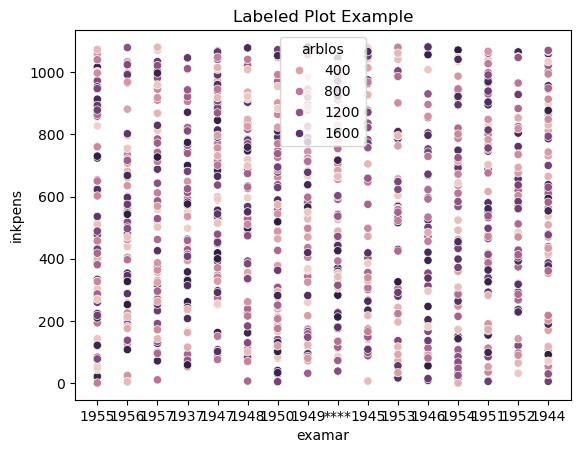

In [33]:
# make a labeled plot
sns.scatterplot(data=lisa_df.lab, x='examar', y='inkpens', hue='arblos')
plt.title("Labeled Plot Example")
plt.show()



In [34]:
lisa_df.lab.value_labels['arblos']

{'1': 'Yes',
 '2': 'No',
 '77': 'No answer',
 '88': 'Partial loss',
 '9': 'Partial loss',
 '0': 'No'}

### 5.4 Regression analysis

We can also include the labeled data in regression analysis

In [33]:

# Use lisa_df.rs directly with original column names
X = lisa_df.lab[['dispinkfam04']]  # This will return a DataFrame with labeled column
y = lisa_df.lab['dispink04']       # This will return a Series with label as name

X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                            OLS Regression Results                                            
==============================================================================================================
Dep. Variable:     Subcomponent of disposable income, 2004 definition   R-squared:                       0.000
Model:                                                            OLS   Adj. R-squared:                 -0.001
Method:                                                 Least Squares   F-statistic:                    0.1111
Date:                                                Mon, 17 Mar 2025   Prob (F-statistic):              0.739
Time:                                                        00:41:06   Log-Likelihood:                -12557.
No. Observations:                                                1000   AIC:                         2.512e+04
Df Residuals:                                                     998   BIC:                         2.513e+04
Df Model:                                                           1                                         
Covariance Type:                                            nonrobust                                         
==============================================================================================================
                                                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
const                                       1.083e+05   4070.055     26.614      0.000       1e+05    1.16e+05
Disposable income, family, 2004 definition     0.0103      0.031      0.333      0.739      -0.050       0.071
==============================================================================
Omnibus:                      469.678   Durbin-Watson:                   2.111
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               56.378
Skew:                           0.123   Prob(JB):                     5.73e-13
Kurtosis:                       1.863   Cond. No.                     2.47e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.47e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## 6. Autolabel Lookup

We also provide a function to lookup any variables (by variable name) in the RegiStream domains. Here is example searching Statistics Sweden (SCB)

In [31]:
# lookup a variable
lookup('astsni2007', domain='scb', lang='eng')

------------------------------------------------------------------------------------------
| VARIABLE:     astsni2007
| LABEL:        Branch of industry for statistics, main
| DEFINITION:   Main branch of industry according to the Swedish classification of ind
|               ustries (SNI), set for statistical purposes.¶
| VALUE LABELS: 00000: Unknown
|               01110: Growers of cereals (except rice), pulses and oilseeds
|               01120: Rice farmer
|               01131: Potato grower
|               01132: Sugar beet growers
|               01133: Grower of vegetables in open field
|               01134: Grower of vegetables in greenhouse
|               01135: Mushroom growers, etc.
|               (and 814 more labels)
------------------------------------------------------------------------------------------
